In [2]:
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
import mxnet.ndarray as nd
import numpy as np
ctx = mx.gpu()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
mnist = mx.test_utils.get_mnist()
num_examples = 1000
batch_size = 64
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["train_data"][:num_examples],
                               mnist["train_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["test_data"][:num_examples],
                               mnist["test_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=False)

In [4]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(10))

In [5]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

In [6]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [7]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.0})

In [8]:
def evaluate_accuracy(data_iterator, net, loss_fun):
    acc = mx.metric.Accuracy()
    loss_avg = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        output = net(data)
        loss = loss_fun(output, label)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return acc.get()[1], loss_avg

def plot_learningcurves(loss_tr,loss_ts, acc_tr,acc_ts):
    xs = list(range(len(loss_tr)))

    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)

    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'testing loss'],fontsize=14)

    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'testing accuracy'],fontsize=14)

Completed epoch 1. Train Loss: 2.24839419127, Test Loss 2.24408787489, Train_acc 0.13, Test_acc 0.156
Completed epoch 21. Train Loss: 0.899072412401, Test Loss 1.10395382345, Train_acc 0.828, Test_acc 0.731
Completed epoch 41. Train Loss: 0.65595632419, Test Loss 0.873232938349, Train_acc 0.852, Test_acc 0.765
Completed epoch 61. Train Loss: 0.544534258544, Test Loss 0.769050188363, Train_acc 0.877, Test_acc 0.787
Completed epoch 81. Train Loss: 0.483852323145, Test Loss 0.70743092522, Train_acc 0.89, Test_acc 0.8
Completed epoch 101. Train Loss: 0.442101042718, Test Loss 0.665659986436, Train_acc 0.897, Test_acc 0.806
Completed epoch 121. Train Loss: 0.409013617784, Test Loss 0.634742515162, Train_acc 0.909, Test_acc 0.813
Completed epoch 141. Train Loss: 0.381803262979, Test Loss 0.61156892404, Train_acc 0.916, Test_acc 0.815
Completed epoch 161. Train Loss: 0.358094744384, Test Loss 0.593733388931, Train_acc 0.923, Test_acc 0.818
Completed epoch 181. Train Loss: 0.342567927204, Test

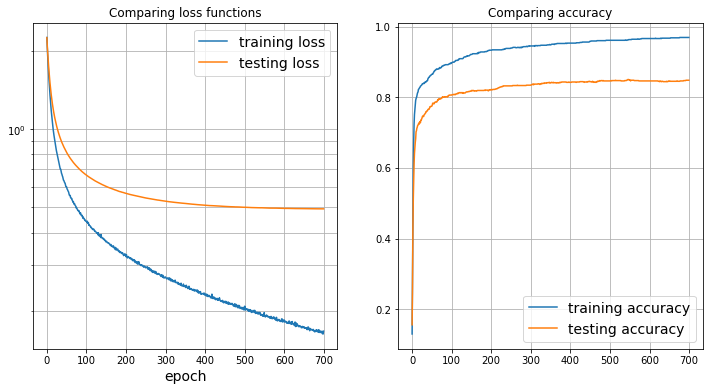

In [9]:
epochs = 700
moving_loss = 0.
niter=0

loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
        cross_entropy.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(cross_entropy).asscalar()
        est_loss = moving_loss/(1-0.99**niter)

    test_accuracy, test_loss = evaluate_accuracy(test_data, net, loss)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net, loss)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)


    if e % 20 == 0:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))

## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)

Completed epoch 1. Train Loss: 2.10321122408, Test Loss 2.11413957179, Train_acc 0.293, Test_acc 0.29
Completed epoch 21. Train Loss: 0.88969765231, Test Loss 1.09512688592, Train_acc 0.824, Test_acc 0.726
Completed epoch 41. Train Loss: 0.653147812933, Test Loss 0.872258745134, Train_acc 0.852, Test_acc 0.758
Completed epoch 61. Train Loss: 0.552538625896, Test Loss 0.76980554685, Train_acc 0.874, Test_acc 0.783
Completed epoch 81. Train Loss: 0.486111592501, Test Loss 0.708424698561, Train_acc 0.888, Test_acc 0.797
Completed epoch 101. Train Loss: 0.448814529926, Test Loss 0.667522538453, Train_acc 0.899, Test_acc 0.807
Completed epoch 121. Train Loss: 0.414396831766, Test Loss 0.637258417904, Train_acc 0.91, Test_acc 0.814
Completed epoch 141. Train Loss: 0.387902207673, Test Loss 0.614717189223, Train_acc 0.916, Test_acc 0.822
Completed epoch 161. Train Loss: 0.365817133337, Test Loss 0.596042897552, Train_acc 0.92, Test_acc 0.824
Completed epoch 181. Train Loss: 0.347142514773, Te

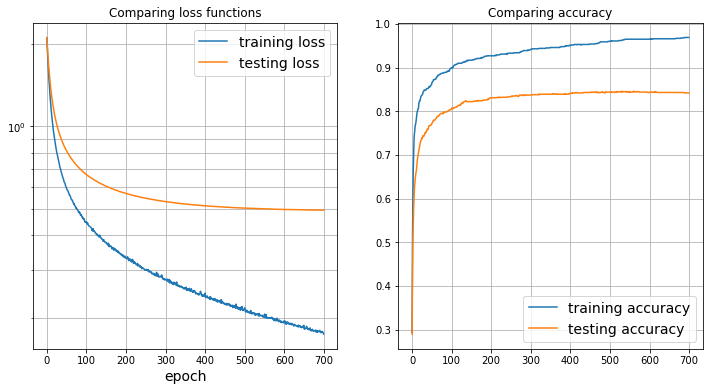

In [10]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx, force_reinit=True)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.001})

moving_loss = 0.
niter=0
loss_seq_train = []
loss_seq_test = []
acc_seq_train = []
acc_seq_test = []

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
        cross_entropy.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        niter +=1
        moving_loss = .99 * moving_loss + .01 * nd.mean(cross_entropy).asscalar()
        est_loss = moving_loss/(1-0.99**niter)

    test_accuracy, test_loss = evaluate_accuracy(test_data, net,loss)
    train_accuracy, train_loss = evaluate_accuracy(train_data, net, loss)

    # save them for later
    loss_seq_train.append(train_loss)
    loss_seq_test.append(test_loss)
    acc_seq_train.append(train_accuracy)
    acc_seq_test.append(test_accuracy)

    if e % 20 == 0:
        print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
              (e+1, train_loss, test_loss, train_accuracy, test_accuracy))

## Plotting the learning curves
plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)